In [1]:
%reset
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import defmod as dm
import multimodule_usefulfunctions as mm 
import hamiltonian_multishape as ham
import kernels as ker
import model_MultiShapeCirclesTranslation as model

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
## define reference and template shape
r = [3,2]
origin1 = [[-3,0], [6,6]]
origin2 = [[0,3], [6,4]]
nb_points = [10,7]

source = mm.multipleCircles(origin1, r ,nb_points)
target = mm.multipleCircles(origin2, r ,nb_points)

In [3]:
## Define Deformation Modules
dim = 2
nb_shapes = 2

# Module 1: Translation of first circle
sigma1 = 10
trans1 = dm.deformationmodules.Translations(dim, 1, sigma1)

# Module 2: Translation of second circle
sigma2 = 10
trans2 = dm.deformationmodules.Translations(dim,1, sigma2)

# Module 3: Background Module
sigma3 = 1.5
nb_pts = nb_points[0] + nb_points[1]
background = dm.deformationmodules.Translations(dim, nb_pts, sigma3)


module_list = [trans1, trans2, background]
dim_controls = dim*(1+1+nb_pts)
gd_list = [source[0], source[1], torch.cat([source[0], source[1]],0)]

In [4]:
target_list = [*target, torch.cat([target[0], target[1]])]

In [5]:
sigma_list = [sigma1, sigma2, sigma3]
z = [mm.computeCenter(source[0]), mm.computeCenter(source[1])]

#initialize gd and momentum
mom_tmp0 = np.zeros([nb_points[0], dim])
mom_tmp1 = np.zeros([nb_points[1], dim])
gd0_list = [source[0], source[1], torch.cat([source[0], source[1]],0)]
mom0_list = [torch.tensor(mom_tmp0.copy(), requires_grad=True, dtype=torch.float32), torch.tensor(mom_tmp1.copy(),requires_grad=True, dtype=torch.float32), torch.tensor(np.zeros(gd_list[2].shape),requires_grad=True, dtype=torch.float32)]

# Constraints (identity)
Constr1 = torch.cat([torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]]), -torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]])], 1)
Constr2 = torch.cat([torch.zeros([nb_points[1], nb_points[0]]), torch.eye(nb_points[1]), torch.zeros([nb_points[1], nb_points[0]]), -torch.eye(nb_points[1]),], 1)
Constr = [Constr1, Constr2]

# reduced Hamiltonian 
dim_control = [[1,2], [1,2], [nb_pts,2]]
H = ham.Hamiltonian_Multishape(module_list, dim_control)

In [6]:
# set parameters
reg_param = 10**-2 # regularisation parameter

gd0_tensor = torch.cat([gd0_list[0], gd0_list[1], gd0_list[2]],0)
mom0_tensor = torch.cat([mom0_list[0], mom0_list[1], mom0_list[2]],0)
    
EnergyFunctional = model.EnergyFunctional(module_list, H, Constr, target_list, sigma_list, dim, reg_param)
gradE = torch.autograd.grad(EnergyFunctional.energy_tensor(gd0_tensor, mom0_tensor), mom0_tensor)
    
# do registration
X = [gd0_tensor, mom0_tensor]
X = model.gradientdescent(EnergyFunctional.energy_tensor, EnergyFunctional.gradE, X)

 iter : 0  ,total energy: 33.1301155090332
convergence False
 iter : 1  ,total energy: 32.958900451660156
convergence False
 iter : 2  ,total energy: 32.78782653808594
convergence False
 iter : 3  ,total energy: 32.61687469482422
convergence False
 iter : 4  ,total energy: 32.44607162475586
convergence False
 iter : 5  ,total energy: 32.275394439697266
convergence False
 iter : 6  ,total energy: 32.1048583984375
convergence False
 iter : 7  ,total energy: 31.93443489074707
convergence False
 iter : 8  ,total energy: 31.7641658782959
convergence False
 iter : 9  ,total energy: 31.594026565551758
convergence False
 iter : 10  ,total energy: 31.42402458190918
convergence False
 iter : 11  ,total energy: 31.254152297973633
convergence False
 iter : 12  ,total energy: 31.084421157836914
convergence False
 iter : 13  ,total energy: 30.914833068847656
convergence False
 iter : 14  ,total energy: 30.745365142822266
convergence False
 iter : 15  ,total energy: 30.576047897338867
convergence Fal

 iter : 129  ,total energy: 12.411282539367676
convergence False
 iter : 130  ,total energy: 12.265782356262207
convergence False
 iter : 131  ,total energy: 12.120651245117188
convergence False
 iter : 132  ,total energy: 11.975885391235352
convergence False
 iter : 133  ,total energy: 11.831501007080078
convergence False
 iter : 134  ,total energy: 11.687506675720215
convergence False
 iter : 135  ,total energy: 11.543903350830078
convergence False
 iter : 136  ,total energy: 11.400697708129883
convergence False
 iter : 137  ,total energy: 11.257895469665527
convergence False
 iter : 138  ,total energy: 11.115500450134277
convergence False
 iter : 139  ,total energy: 10.973536491394043
convergence False
 iter : 140  ,total energy: 10.854568481445312
convergence False
 iter : 141  ,total energy: 10.75047492980957
convergence False
 iter : 142  ,total energy: 10.625929832458496
convergence False
 iter : 143  ,total energy: 10.5276460647583
convergence False
 iter : 144  ,total energy: 

In [24]:
# check if autograd is correct

#torch.autograd.gradcheck(EnergyFunctional.energy_tensor, (gd0_tensor, mom0_tensor), eps=1e-2, atol=1e-2, raise_exception=True)


In [28]:
#for i in range(len(control)):
#    z_list = [mm.computeCenter(gd[i][0]), mm.computeCenter(gd[i][1]), gd[i][2]]
#    print(EnergyFunctional.cost(z_list, control[i]))
#control
# the control is constant over time, does that make sense?

In [14]:
# compute final deformation
gd0_final = mm.tensor2list(X[0], [nb_points[0], nb_points[1], nb_points[0]+nb_points[1]])
mom0_final = mm.tensor2list(X[1], [nb_points[0], nb_points[1], nb_points[0]+nb_points[1]])

gd_t, mom_t, controls_t = mm.shootMultishape(gd0_final, mom0_final, H, Constr, sigma_list, dim, n=10)


In [16]:
nb_modules = 2
N = len(controls_t)
center_t = torch.zeros( N, nb_modules, dim)
for t in range(N):
    for m in range(2):
        center_t[t, m] = mm.computeCenter(gd_t[t][m])

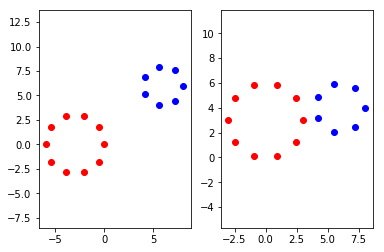

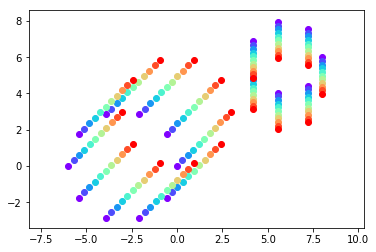

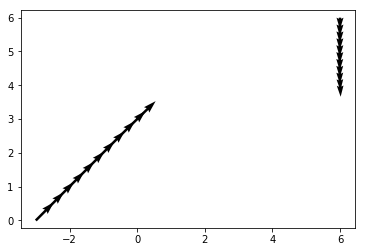

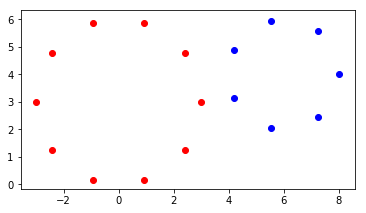

In [30]:
import matplotlib.cm as cm

# Geometrical descriptors at initial time
fig = plt.figure()
plt.subplot(1,2,1)  
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

# target
plt.subplot(1,2,2)  
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

# Geometrical Descriptors transported over time by shooting
fig2 = plt.figure()  
colors = cm.rainbow(np.linspace(0, 1, len(gd_t)))
for i,c in zip(range(len(gd_t)), colors):
    plt.scatter(gd_t[i][0][:,0].detach().numpy(), gd_t[i][0][:, 1].detach().numpy(), color=c)
    plt.scatter(gd_t[i][1][:,0].detach().numpy(), gd_t[i][1][:, 1].detach().numpy(), color=c)
plt.axis('equal')

# controls over time
fig3 = plt.figure()  
for i in range(len(controls_t)):
    mm.plotControl(controls_t[i], [center_t[i][0],center_t[i][1]])
plt.axis('equal')

# target
fig4 = plt.figure()  
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')
plt.gca().set_adjustable("box")


plt.show()